In [1]:
%load_ext autoreload
%autoreload 2

# Diffeomorphisms and Derivative Bounds

In this notebook we attempt to visualize the theoretical bounds of the $C^k$-norms of vector fields on the form
$$
    f_L \circ ... \circ f_1 - id_\Omega,
$$
as given in the Theorem 4.1 of the shape-paper. Moreover, we want to compare theese bounds to the norms achieved in practice. The best way to visualize the practically achieved norms will have to be determined after some experimentation, but 2 ideas come to mind:

1. Create functions from random weights samples. Plot average, median max and min achieved amongst these functions.
2. Create randomly sampled "weight directions". See how the norms differ as I make the size of the weights direction larger.


Before I can perform the experiments I need to do the following:
- [ ] Find the exact definition of the $C^k$-norms with vector valued functions.
- [ ] Implement n-th derivatives in pytorch.
    - [x] 1D
    - [ ] 2D
- [x] Implement functions sampling approach.
- [x] Plot the listed values for $M_k$ upper bound.
- [x] Implement a $C^k$-norm finder (e.g. sampling from domain, and plotting max-norm.

## Derivatives and $C^k$-norms

Cases:
* 1D input -> 1D output
* 2D input -> 2D output

We start with the simple case of one-dimensional diffeomorphisms. Then
$$
    \|f\|_{C^k} = \sup_{x\in\Omega} |f^{(k)}(x)| \approx \max_{x_i \in X} |f(x_i)|
$$
where $X = {x_i}$ is "tight" collection of points on $\Omega$.

### Theoretical Bound

In [2]:
import deepshape as ds
import matplotlib.pyplot as plt
import numpy as np
import torch


from numpy import pi
from torch import sin
from torch.autograd import grad

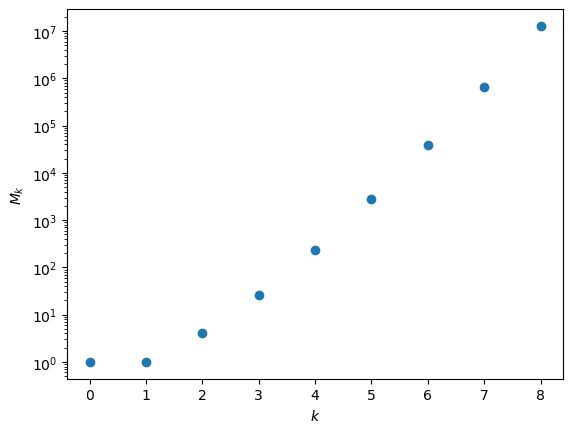

In [3]:
Mk = torch.tensor([
    1, 1, 4, 26, 236, 2752, 39208, 660032, 12818912#, 282137824
])
k_max = len(Mk)
plt.semilogy(Mk, 'o')
plt.xlabel('$k$')
plt.ylabel("$M_k$")
plt.show()

### Derivatives of One-Dimensional Functions

Start with implementing derivatives for functions $f: \mathbb{R} \to \mathbb{R} $. As a test-case we use the function
$$
    f(x) = x^4.
$$

Then
$$
    f'(x) = 4x^3\\
    f''(x) = 12  x^2\\
    f'''(x) = 24  x\\
    f^{(4)}(x) = 24.\\
    f^{(n)}(x) = 0. \; n\geq 5.
$$

Since we want to check for multiple points $x_i$ simoultaneously, let $g: \mathbb{R}^N \to \mathbb{R}^N$ be defined by 
$$
    g(X) = \sum_{x_i \in X} f(x_i).
$$
Then $$\partial_{x_i} g(X) = f'(x_i),$$ such that the gradient of g is just the collections of derivatives.

In [5]:
def torch_nth_derivative(f, x, n):
    if x.requires_grad:
        detach = False
    else:
        detach = True
        x.requires_grad = True
    
    g = f(x).sum()
    dx = f(x)

    for i in range(n):
        dx = grad(g, x, create_graph=True)[0]
        g = dx.sum()
        
    if detach:
        x.requires_grad = False
        return dx.detach()
    
    return dx

test_function = {
    0: lambda x: x**4,
    1: lambda x: 4 * x**3,
    2: lambda x: 12 * x**2,
    3: lambda x: 24 * x,
    4: lambda x: 24 * torch.ones_like(x),
    5: lambda x: torch.zeros_like(x)
}
f = test_function[0]


# Check derivatives of f up to order 5
x = torch.linspace(0, 1, 101)
for n in range(6):
    print(torch.allclose(torch_nth_derivative(test_function[0], x, n), test_function[n](x)))

True
True
True
True
True
True


In [6]:
def idty(x):
    return x

def sin_vector_field(weights):
    n = weights.numel()
    N = torch.arange(1, n+1, dtype=torch.float32)
    weights = weights.float()
    
    def evaluate(x):
        return (weights * torch.sin(pi * N * x) / (pi * N)).sum(dim=-1, keepdims=True)
    
    return evaluate

# Test
x = torch.linspace(0, 1, 101).reshape(-1, 1)
for i in range(1, 6):
    w = torch.zeros(5)
    w[i-1] = 1.
    fi = sin_vector_field(w)
    print(torch.allclose(fi(x), torch.sin(pi * i * x)/ (pi * i), atol=1e-6))
    print(torch.allclose(torch_nth_derivative(fi, x, 1), torch.cos(pi * i * x), atol=1e-6))

True
True
True
True
True
True
True
True
True
True


### Practical Bounds on Derivatives

Finding the function bounds for these functions in practice requires some kind of random sampling of functions, or a predetermined way of choosing the weights.

We first attempt a deterministic approach for choosing these bounds; Choose a weight vector on the form $ w = a\mathbb{1}$ for some scalar a, and investigate how the bound develops as we increase the value of $a$. In this setting, we are able to modify two parameters:
* $L$ : The number of layers.
* $n$ : The number of basis functions per layer.

In [7]:
class SineVectorField:
    def __init__(self, weights):
        self.d = weights.numel()
        self.N = torch.arange(1, self.d+1, dtype=torch.float32)
        self.weights = weights.float()
        
    def __call__(self, x):
        return (self.weights * torch.sin(pi * self.N * x) / (pi * self.N)).sum(dim=-1, keepdims=True)
    
    
class ComposedVectorfield:
    def __init__(self, vector_field_collection):
        self.collection = vector_field_collection
        
    def __call__(self, x):
        y = x
        for fl in self.collection:
            y = y + fl(y)
        return y - x
    
    def get_weight_matrix(self):
        return torch.stack([fi.weights for fi in torch.collection])
    
    


In [8]:
def grid_evaluate(f, N):
    xx = torch.linspace(0, 1, N).reshape(-1, 1)
    return f(xx)

def approx_max_norm(f, k, npoints=int(1e4)):
    xx = torch.linspace(0, 1, npoints).view(-1, 1)
    df = torch_nth_derivative(f, xx, n=npoints)
    return df.norm(np.inf)

def compose_vector_fields(vecfield_collection):
    def evaluate(x):
        y = x
        for fl in vecfield_collection:
            y = y + fl(y)
        return y - x
    return evaluate

def compute_composed_bound(function_collection, k=0, npoints=int(1e4)):
    F = compose_vector_fields(function_collection)
    field_sum = float(torch.stack(
        [approx_max_norm(fi, k=k, npoints=npoints) for fi in function_collection]).sum())
    return approx_max_norm(F, k) / (np.exp(k) * field_sum)

def find_bound_weights_first(L, d, k):
    W = torch.ones(L, d)
    W = scale_weight_collection(W, k)
    F = [sin_vector_field(wi) for wi in W]
    return compute_composed_bound(F, k)

In [9]:
n = 1  # Number of basis functions per vector field.
k = 1  # Derivative order (for C^k norms)
m = 1  # Number of samples (not needed for deterministic functions)
L = 8  # Number of layers in composition

a = 1.  #  Scaling coefficient
w = a * torch.ones(n)  # Weight vector


x = torch.linspace(0, 1, 401).view(-1, 1)
f = Sine(w)
collection = [lambda x: f(x) for _ in range(L)]
F = compose_vector_fields(collection)
F = 

plt.figure()
plt.plot(x, x + f(x))
plt.plot(x, x + F(x))
plt.show()


print(compute_composed_bound(collection, k=3))

SyntaxError: invalid syntax (<ipython-input-9-6259f7aad595>, line 14)

#### Sampling Functions 

In [10]:
def random_sample_normal(n, mean=0.0, std=1.0):
    return sin_vector_field(mean + std * torch.randn(n))


def scale_weight_collection(W, k):
    L, d = W.shape
    N = torch.arange(1, d+1) 
    scalar = (torch.abs(W) * (N * pi)**(k-1)).sum()
    
    if scalar >= 1 - 1e-8:
        W *= (1-1e-8) / scalar
    
    return W

In [11]:
M = 3
K = 1024**6
K = 2 

# Evaluate function samples.
function_samples = [random_sample_normal(30, mean=0., std=1.) for i in range(M)]
function_evaluations = torch.cat([grid_evaluate(fi, K) for fi in function_samples], dim=-1)
norms = torch.tensor([approx_max_norm(fi) for fi in function_samples])

for fi in function_samples:
    print(fi(x).norm(np.inf))
# Compute some statistics
mean = norms.mean()
std = norms.std()
ck_norm_max = norms.max()
ck_norm_min = norms.min()

plt.figure()
for fi in function_samples:
    plt.plot(x, fi(x))
plt.show()

plt.bar([0, 1, 2, 3], [mean, ck_norm_max, ck_norm_min, std])
plt.xticks([0, 1, 2, 3], ["mean", "max", "min", "std"])
plt.show()


xx = torch.linspace(0, 1, 10000).view(-1, 1)
F = compose_vector_fields(function_samples)
plt.plot(xx, F(xx))
plt.show()

print(approx_max_norm(F))
print(compute_composed_bound(function_samples))

TypeError: approx_max_norm() missing 1 required positional argument: 'k'

# Interesting Concept: Approximating $L^2$-functions by composition of Fourier Series

* Eliminating basis functions, by showing equality between fourier series representation of sawtooth, and composition-representation of sawtooth. 

In [1]:
n = 12  # Number of basis functions per vector field.
k = 1  # Derivative order (for C^k norms)
m = 1  # Number of samples (not needed for deterministic functions)
L = 10  # Number of layers in composition

a = 1.  #  Scaling coefficient
w = a * torch.ones(n)  # Weight vector
w = torch.zeros(n)
i = 2
w[i] = 1
w[i+1] = 1
w[i-1] = -1

x = torch.linspace(0, 1, 301).view(-1, 1)
f = sin_vector_field(w)
F = compose_vector_fields([lambda x: f(x) for _ in range(L)])

plt.figure()
plt.plot(x, f(x))
plt.plot(x, F(x))
plt.show()

print(float(approx_max_norm(lambda x: torch_nth_derivative(F, x, k))))

NameError: name 'torch' is not defined

## Attempt Projection Directly at weight Collection 

1. Sample weights
2. Project weights
3. Create vector fields from weight collection
4. Compute bounds for the2

In [ ]:
find_bound_weights_first(L, d, k)

In [ ]:
def approximate_vector_field_norm_sum(collection, k, npoints=)
field_sum = float(torch.stack(
        [approx_max_norm(fi, k=k, npoints=npoints) for fi in function_collection]).sum())

In [2]:
L_list = list(range(1, 10))
d = 10
plt.figure()
plt.plot(L_list, [find_bound_weights_first(li, d, k=1) for li in L_list], label=f"k=1")
plt.plot(L_list, [find_bound_weights_first(li, d, k=2) for li in L_list], label=f"k=2")
plt.plot(L_list, [find_bound_weights_first(li, d, k=5) for li in L_list], label=f"k=5")
plt.legend()
plt.show()

NameError: name 'plt' is not defined

In [59]:
def test_repeating_cos(x, L, n=1):
    y = x
    for _ in range(L):
        y = y + sin(n * pi * y)
    return y - x

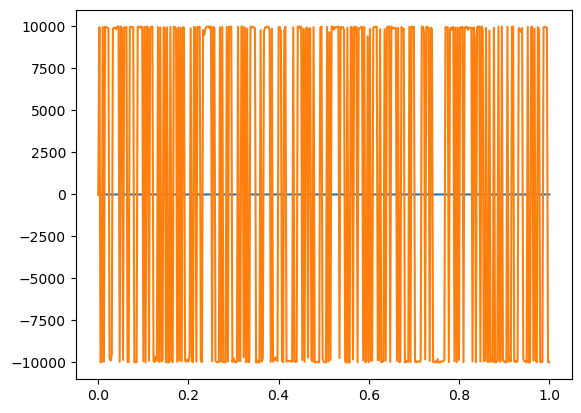

In [94]:
x = np.linspace(0, 1, 401)
plt.plot(x, test_repeating_cos(x, 1))
plt.plot(x, test_repeating_cos(x, 10000, n=`))
plt.show()

In [19]:
def test_alternating_sin_cos(x, L=1):
    y = x
    for l in range(L):
        y = sin(cos(y) - y) - y
    return y

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import sin, cos, pi 

In [21]:
x = np.linspace(0, 1, 101)

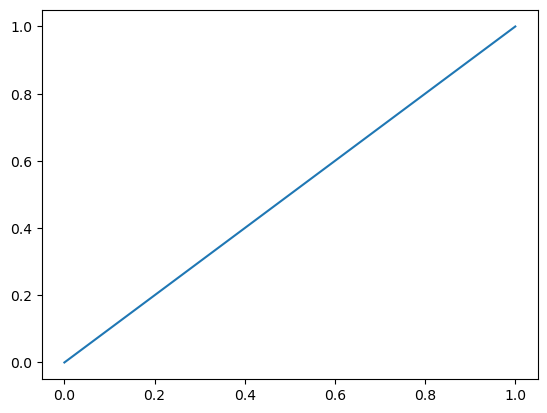

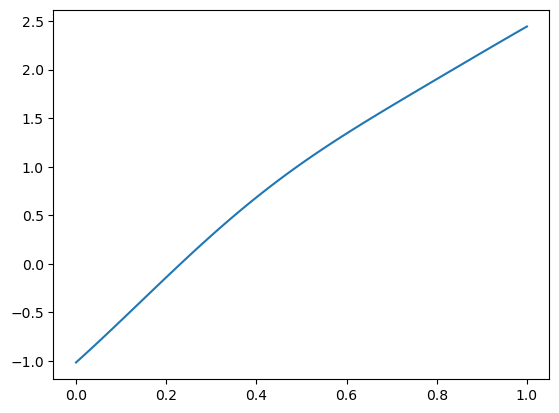

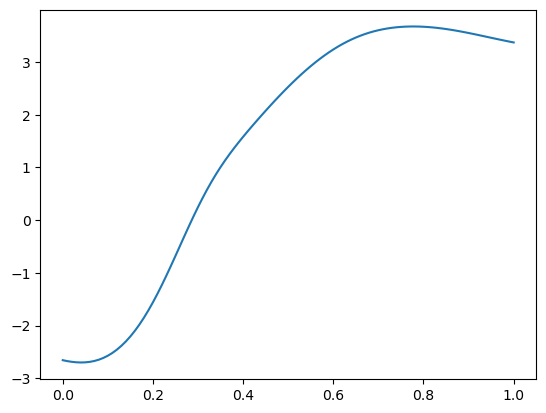

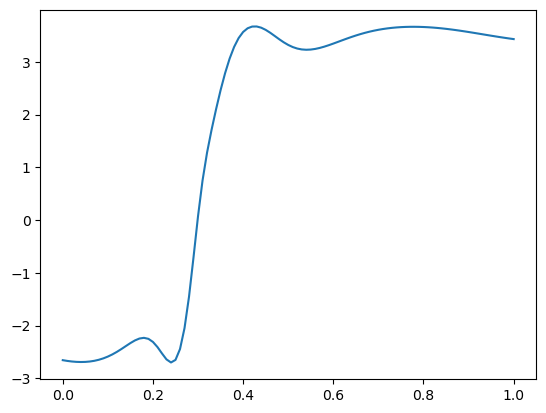

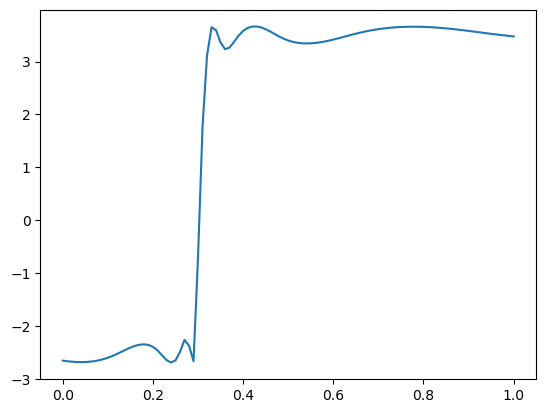

In [24]:
for l in range(0, 10, 2):
    plt.plot(x, test_alternating_sin_cos(x, l))
    plt.show()